In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from time import time

from scipy.special import comb, loggamma, lambertw
from scipy.stats import multinomial, expon

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import tensorflow_probability as tfp

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

import os, shutil
from pathlib import Path
import json
import subprocess

from net_model import *
from custom_model import *
from mps_models import *

import mps
import pwexp

E0000 00:00:1742392479.244162 1104285 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742392479.247602 1104285 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1742392480.993627 1104285 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/natan/.pyenv/versions/3.10.16/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mri = np.load("OASIS - Small Dataset/mri_train_test.npz")
img_oasis = mri["images"]

In [3]:
def plot_S1(distribution, q, end_index = 101, ci = True, show_sims = True, color = "red", ax = None, outliers = 0):
    tv = np.arange(0, 12, 0.1)
    
    s_t_xie = np.array([0, 2.062, 3.36, 4.495, 6.32, 12.2])
    alpha_xie = np.array([0.02872308, 0.04870019, 0.10390695, 0.16946955, 0.5868493 , 1])
    S1_tv_xie = S1(tv, alpha_xie, s_t_xie)
    
    if(ax is None):
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

    S1_table = np.zeros((end_index-1, len(tv)))
    
    for i in range(1, end_index):
        data_alpha_s = pd.read_csv("OASIS - Results/{}/{}/alpha_s.csv".format(distribution, i))
        alpha = data_alpha_s["alpha"].to_numpy()
        s_t = data_alpha_s["s"].to_numpy()
        
        S1_tv = S1(tv, alpha, s_t)
        S1_table[i-1, :] = S1_tv

        if(show_sims):
            ax.plot(tv, S1_tv, color = color, alpha = 0.1)
    
    # Obtain the median survival curve
    S1_median = np.quantile(S1_table, 0.50, axis = 0)
    # Takes the mean squared distances of all curves to the median
    median_distances = np.mean( (S1_table - S1_median)**2, axis = 1 )
    # Sorts the distances vector to get the ranks of each curve (i.e. sorts the curves by distance from the median curve)
    index_sort_distances = np.argsort(np.argsort( median_distances ))
    
    # Remove from the table of curves the prespecified number of outlier curves (which are discarded for the predictions)
    S1_table = S1_table[ index_sort_distances < (end_index - 1 - outliers) , :]    
    
    S1_q025 = np.quantile(S1_table, q = 0.05, axis = 0)
    S1_median = np.median(S1_table, axis = 0)
    S1_mean = np.mean(S1_table, axis = 0)
    S1_q975 = np.quantile(S1_table, q = 0.975, axis = 0)

    ax.plot(tv, S1_mean, color = color, label = distribution)
    if(ci):
        ax.plot(tv, S1_q025, color = color, linestyle = "dashed")
        ax.plot(tv, S1_q975, color = color, linestyle = "dashed")
    
    ax.plot(tv, S1_tv_xie, color = "black")

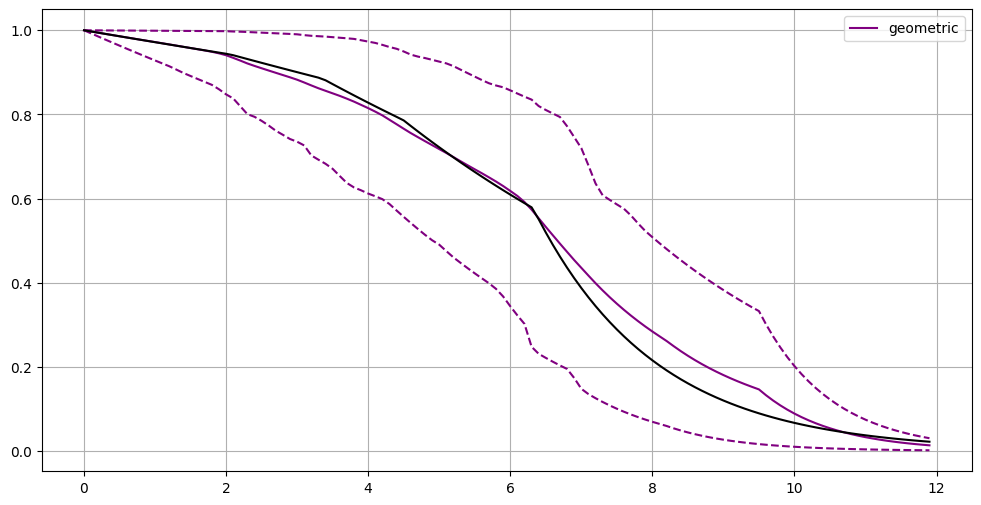

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

# plot_S1("poisson", None, 101, ci = True, show_sims = False, color = "red", ax = ax, outliers = 5)
# plot_S1("haight", None, 101, ci = True, show_sims = False, color = "blue", ax = ax, outliers = 5)
# plot_S1("borel", None, 101, ci = True, show_sims = False, color = "green", ax = ax, outliers = 5)
plot_S1("geometric", None, 64, ci = True, show_sims = False, color = "purple", ax = ax, outliers = 5)

plt.grid()
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def ROC_real(cured, pred_p):
    fpr, tpr, thresholds = roc_curve(cured, pred_p, drop_intermediate = False)
    return fpr, tpr, thresholds

def AUC_real(cured, pred_p):
    fpr, tpr, thresholds = ROC_real(cured, pred_p)
    return auc(fpr, tpr)

def ROC_estimated(pred_p):
    thresholds = np.unique(pred_p)
    # Reshape the cure_probs array for broadcasting
    pred_p = np.reshape(pred_p, (len(pred_p), 1))
    tpr = np.sum( (pred_p < thresholds) * (1-pred_p), axis = 0 ) / np.sum( 1-pred_p )
    fpr = np.sum( (pred_p < thresholds) * pred_p, axis = 0 ) / np.sum( pred_p )
    return fpr, tpr, thresholds

def AUC_estimated(pred_p):
    fpr, tpr, thresholds = ROC_estimated(pred_p)
    return auc(fpr, tpr)

In [11]:
def load_fitted_model(distribution, q, images, file_index):
    # Select the functions associated to the chosen distribution model
    log_a_str, log_phi_str, C_str, C_inv_str, sup_str, theta_min, theta_max = select_model(distribution, q)
    log_a_tf = eval(log_a_str)
    log_phi_tf = eval(log_phi_str)
    C_tf = eval(C_str)
    C_inv_tf = eval(C_inv_str)
    sup_tf = eval(sup_str)

    simulation_path = "OASIS - Results/{}/{}".format(distribution, file_index)

    # ----------------------- Load data -----------------------
    # Indices for the images associated to this specific sample
    df_sample = pd.read_csv("OASIS - Small Dataset/bootstrap_sample/sample_{}.csv".format(file_index))

    imgs = images[ df_sample["image_index"] ]
    
    # ----------------------- Load results related to the fitted simulation ----------------------- 
    fitted_model = MPScrModel(log_a_tf, log_phi_tf, C_tf, C_inv_tf, sup_tf)
    fitted_model.define_structure(shape_input = images[0].shape)
    fitted_model.load_model("OASIS - Results/{}/{}/model.weights.h5".format(distribution, file_index))
    alpha_s_df = pd.read_csv("OASIS - Results/{}/{}/alpha_s.csv".format(distribution, file_index))
    pred_alpha = alpha_s_df["alpha"].to_numpy()
    s_t = alpha_s_df["s"].to_numpy()

    # ----------------------- Join everything in a single table -----------------------
    log_a_0 = log_a_tf(tf.constant(0.0, dtype = tf.float64))

    t = df_sample["time"].to_numpy()
    delta = df_sample["delta"].to_numpy()
    
    # Obtain all the predictions made using the trained model
    pred_eta = fitted_model.predict(imgs, verbose = 0)
    pred_p = fitted_model.link_func( pred_eta ).numpy().flatten()
    pred_log_p = np.log(pred_p)
    pred_theta = C_inv_tf( np.exp( log_a_0 - pred_log_p ) ).numpy().flatten()
    pred_m = update_m_mps(fitted_model, pred_alpha, s_t, imgs, t, delta)

    pred_S1 = S1(t, pred_alpha, s_t)    
    pred_Spop = Spop_known_S1(pred_S1, log_a_tf, log_phi_tf, pred_theta, sup_tf)
    
    df_summary = pd.DataFrame({"pred_theta": pred_theta, "pred_p": pred_p, "pred_m": pred_m,
                               "t": t, "delta": delta,
                               "pred_S1": pred_S1, "pred_Spop": pred_Spop,
                               "set": df_sample["set"].to_numpy()})

    AUC_train = AUC_estimated( pred_p[df_sample["set"] == "train"] )
    AUC_val = AUC_estimated( pred_p[df_sample["set"] == "val"] )
    AUC_test = AUC_estimated( pred_p[df_sample["set"] == "test"] )
    
    return {
        "fit_model": fitted_model,
        "pred_alpha": pred_alpha,
        "pred_s_t": s_t,
        "imgs": imgs,
        "sets": df_sample["set"].to_numpy(),
        "log_a": log_a_tf,
        "log_phi": log_phi_tf,
        "C": C_tf,
        "C_inv": C_inv_tf,
        "sup": sup_tf,
        "summary": df_summary,
        "AUC_train": AUC_train,
        "AUC_val": AUC_val,
        "AUC_test": AUC_test
    }

def recover_AUCs(distribution, q, images, end_index = 101):
    train_AUCs = []
    val_AUCs = []
    test_AUCs = []
    for j in tqdm(range(1, end_index)):
        results = load_fitted_model(distribution, q, images, j)
        train_AUCs.append( results["AUC_train"] )
        val_AUCs.append( results["AUC_val"] )
        test_AUCs.append( results["AUC_test"] )
    train_AUCs = np.array(train_AUCs)
    val_AUCs = np.array(val_AUCs)
    test_AUCs = np.array(test_AUCs)

    return train_AUCs, val_AUCs, test_AUCs

In [12]:
train_AUCs_poisson, val_AUCs_poisson, test_AUCs_poisson = recover_AUCs("poisson", None, img_oasis, end_index = 101)
# train_AUCs_bernoulli, val_AUCs_bernoulli, test_AUCs_bernoulli = recover_AUCs("bernoulli", None, img_oasis, end_index = 101)
# train_AUCs_logarithmic, val_AUCs_logarithmic, test_AUCs_logarithmic = recover_AUCs("logarithmic", None, img_oasis, end_index = 101)
# train_AUCs_geometric, val_AUCs_geometric, test_AUCs_geometric = recover_AUCs("geometric", None, img_oasis, end_index = 79)
train_AUCs_borel, val_AUCs_borel, test_AUCs_borel = recover_AUCs("borel", None, img_oasis, end_index = 101)
train_AUCs_haight, val_AUCs_haight, test_AUCs_haight = recover_AUCs("haight", None, img_oasis, end_index = 101)

I0000 00:00:1742392542.833171 1104285 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4203 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
  0%|                                                                                                                                                                               | 0/100 [00:00<?, ?it/s]


ValueError: A total of 4 objects could not be loaded. Example error message for object <Conv2D name=conv2d, built=True>:

Layer 'conv2d' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Conv2D name=conv2d, built=True>, <Conv2D name=conv2d_1, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]

In [22]:
result = load_fitted_model("geometric", None, img_oasis, 1)
result["summary"]

pred_theta    pred_p      pred_m          t  delta   pred_S1  pred_Spop  \
0      0.015972  0.984279    0.000169  12.189041      0  0.010764   0.984445   
1      0.057608  0.945529    0.004844  10.082192      0  0.088502   0.950110   
2      1.080784  0.480588    1.179588   9.498630      1  0.158632   0.523742   
3     73.396519  0.013441  102.204596   2.035616      1  0.993982   0.693612   
4      0.021356  0.979091    0.019961   4.663014      0  0.935973   0.998635   
..          ...       ...         ...        ...    ...       ...        ...   
347    0.294050  0.772768    1.511392   5.126027      1  0.896128   0.970362   
348   56.497850  0.017392   12.361205   4.600000      0  0.941532   0.232377   
349    1.497860  0.400343    0.014175  11.416438      0  0.023308   0.406017   
350    0.029244  0.971586    0.028377   3.227397      0  0.971145   0.999157   
351    0.010322  0.989784    0.005321   7.073973      0  0.518049   0.995050   

       set  
0    train  
1    train  
2    train  
3    train  
4    train  
..     ...  
347   test  
348   test  
349   test  
350   test  
351   test  

[352 rows x 8 columns]

In [14]:
train_AUCs_borel, val_AUCs_borel, test_AUCs_borel = recover_AUCs("borel", None, img_oasis, end_index = 101)
train_AUCs_haight, val_AUCs_haight, test_AUCs_haight = recover_AUCs("haight", None, img_oasis, end_index = 101)

  0%|                                                                                                                                                                               | 0/100 [00:01<?, ?it/s]


ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

In [11]:
test_AUCs_geometric

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None], dtype=object)

In [8]:
import seaborn as sns

In [9]:
sns.boxplot(x = )

<function seaborn.categorical.boxplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, fill=True, dodge='auto', width=0.8, gap=0, whis=1.5, linecolor='auto', linewidth=None, fliersize=None, hue_norm=None, native_scale=False, log_scale=None, formatter=None, legend='auto', ax=None, **kwargs)>